# [Quick Practice] 
-----
-----
## Post-Analysis Process - Factorization Machine
#### Using xlearn python-wrapper module (https://xlearn-doc.readthedocs.io/en/latest/)

- Using Titanic dataset. (https://www.kaggle.com/c/titanic)
- Original paper (Steffen Rendle, https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
- Basic Conceptual Description for FM in korean (http://yamalab.tistory.com/107)

-----
-----
## Step 1 : prepare FM model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df1_path = "./dataset/titanic_dataset.csv"
df2_path = "./dataset/titanic_answer.csv"

In [3]:
df1 = pd.read_csv(df1_path)
df2 = pd.read_csv(df2_path)
df = df1.append(df2)

In [4]:
def age_discretize(x):
    if x == np.nan:
        return '10'
    else:
        x = int(x)
        if x < 10:
            return '1'
        elif x < 20 and x >= 10:
            return '2'
        elif x < 30 and x >= 20:
            return '3'
        elif x < 40 and x >= 30:
            return '4'
        elif x < 50 and x >= 40:
            return '5'
        elif x < 60 and x >= 50:
            return '6'
        elif x < 70 and x >= 60:
            return '7'
        elif x < 80 and x >= 70:
            return '8'
        elif x < 90 and x >= 80:
            return '9'
        else:
            return '10'

def fare_discretize(x):
    if x < 10:
        return '1'
    elif x < 20 and x >= 10:
        return '2'
    elif x < 30 and x >= 20:
        return '3'
    elif x < 40 and x >= 30:
        return '4'
    elif x < 50 and x >= 40:
        return '5'
    elif x < 60 and x >= 50:
        return '6'
    elif x < 70 and x >= 60:
        return '7'
    elif x < 80 and x >= 70:
        return '8'
    elif x < 90 and x >= 80:
        return '9'
    else:
        return '10'

In [5]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']]
df = df.dropna()

df['sex'] = df['sex'].apply(lambda x: '1' if x == "female" else '0')
df['age'] = df['age'].apply(lambda x: age_discretize(x))
df['fare'] = df['fare'].apply(lambda x: fare_discretize(int(x)))

df['survived'] = df['survived'].astype('str')
df['pclass'] = df['pclass'].astype('str')
df['sibsp'] = df['sibsp'].astype('str')
df['parch'] = df['parch'].astype('str')

In [6]:
# make discretized label to 1~n dict
def make_encoding_label_dict(col_unique):
    encoded_dict = {}
    for idx, unique in enumerate(col_unique):
        encoded_dict[unique] = idx + 1

    return encoded_dict


# get new encoding result
def get_newcode(key, label_dict):
    com_len = len(label_dict)
    if key == np.nan:
        return
    else:
        if key in label_dict:
            return label_dict[key]
        else:
            return com_len + 1

In [7]:
encoded_sibsp_dict = make_encoding_label_dict(df.sibsp.value_counts().index.tolist())
encoded_parch_dict = make_encoding_label_dict(df.parch.value_counts().index.tolist())

In [8]:
df['sibsp'] = df['sibsp'].apply(lambda x: get_newcode(x, encoded_sibsp_dict))
df['parch'] = df['parch'].apply(lambda x: get_newcode(x, encoded_parch_dict))

In [9]:
col_len_dict = {'pclass': 3, 'sex': 1, 'age': 9, 'sibsp': 7, 'parch': 7, 'fare': 10}
col_accum_index_dict = {}
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

train_df, test_df = train_test_split(df, test_size=0.2)

In [10]:
txt_file = open('./dataset/train.txt', 'w')
for idx, row in train_df.iterrows():
    vec = []
    label = row['survived']
    vec.append(str(label))
    row = row.drop(labels=['survived'])
    for key, value in row.items():
        if col_len_dict[key] == 1:
            if value != '0':
                col_idx = col_accum_index_dict[key]
                out_val = value
                vec.append(str(col_idx) + ":" + str(out_val))
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [11]:
txt_file = open('./dataset/test.txt', 'w')
for idx, row in test_df.iterrows():
    vec = []
    label = row['survived']
    vec.append(str(label))
    row = row.drop(labels=['survived'])
    for key, value in row.items():
        if col_len_dict[key] == 1:
            if value != '0':
                col_idx = col_accum_index_dict[key]
                out_val = value
                vec.append(str(col_idx) + ":" + str(out_val))
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

-----
-----
## Step 2 : learn FM model

In [68]:
import xlearn as xl

def runner(param, txt_file='./model.txt'):
    fm_model = xl.create_fm()

    train_path = './dataset/train.txt'
    test_path = './dataset/test.txt'

    fm_model.setTrain(train_path)
    fm_model.setValidate(test_path)

    # Start to train : fit이 seTXTModel 보다 뒤에 있어야만 model.txt가 생성됨.
    fm_model.setTXTModel(txt_file)
    fm_model.fit(param, './model.out')

    # Prediction task
    fm_model.setTest(test_path)
    fm_model.setSigmoid()

    # Start to predict
    fm_model.predict("./model.out", "./output.txt")

In [191]:
# 실험군
txt_file = './abnormal.txt'
param = {'task':'binary',
         'epoch': 3,
         'lr': 0.002,
         'lambda': 0.1,
         'k': 4,
         'metric': 'auc', 
         'opt': 'sgd'}
runner(param, txt_file=txt_file)

In [190]:
# 대조군
txt_file = './normal.txt'
param = {'task':'binary',
         'epoch': 15,
         'lr': 0.1,
         'lambda': 0.002,
         'k': 8,
         'metric': 'auc',
         'opt': 'adagrad'}
runner(param, txt_file=txt_file)

-----
-----
## Step 3 : Analyze FM's vectors

- Compare normal params VS abnormal params

In [200]:
txt_path = './normal.txt'

k = 8
w_0 = {}
w_i = {}
v_ik = {}
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            w_0[cut_line[0]] = cut_line[1]
        elif "i" in cut_line[0]:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            w_i[cut_line[0]+"_"+name] = cut_line[1]
        else:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            v_ik[cut_line[0]+"_"+name] = {}
            v_k = cut_line[1].strip().split(' ')
            for f in range(k):
                v_ik[cut_line[0]+"_"+name][f] = float(v_k[f])

In [201]:
normal_w_0 = w_0
normal_w_i = w_i
normal_v_ik = v_ik

In [202]:
txt_path = './abnormal.txt'

k = 4
w_0 = {}
w_i = {}
v_ik = {}
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            w_0[cut_line[0]] = cut_line[1]
        elif "i" in cut_line[0]:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            w_i[cut_line[0]+"_"+name] = cut_line[1]
        else:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            v_ik[cut_line[0]+"_"+name] = {}
            v_k = cut_line[1].strip().split(' ')
            for f in range(k):
                v_ik[cut_line[0]+"_"+name][f] = float(v_k[f])

In [203]:
abnormal_w_0 = w_0
abnormal_w_i = w_i
abnormal_v_ik = v_ik

-----

In [205]:
normal_v_ik

{'v_0_pclass': {0: 0.145897,
  1: 0.137539,
  2: 0.214149,
  3: 0.349976,
  4: 0.358427,
  5: 0.155407,
  6: 0.245954,
  7: 0.178882},
 'v_1_pclass': {0: 0.0754734,
  1: 0.206675,
  2: 0.0253535,
  3: 0.136588,
  4: 0.16604,
  5: 0.180926,
  6: 0.149988,
  7: 0.137954},
 'v_2_pclass': {0: 0.0267583,
  1: 0.100057,
  2: 0.0155853,
  3: 0.0178282,
  4: -0.0645885,
  5: -0.039075,
  6: 0.0542967,
  7: 0.0277555},
 'v_3_sex': {0: 0.477217,
  1: 0.419632,
  2: 0.283619,
  3: 0.555735,
  4: 0.572946,
  5: 0.378615,
  6: 0.454913,
  7: 0.304823},
 'v_4_age': {0: 0.1005,
  1: 0.151524,
  2: 0.113087,
  3: 0.222345,
  4: 0.208699,
  5: 0.181377,
  6: 0.158879,
  7: 0.0576632},
 'v_5_age': {0: 0.146877,
  1: 0.116064,
  2: 0.132668,
  3: 0.211374,
  4: 0.145101,
  5: 0.18706,
  6: 0.0381503,
  7: 0.055027},
 'v_6_age': {0: 0.0851252,
  1: 0.185806,
  2: 0.0424193,
  3: 0.0695483,
  4: 0.175815,
  5: 0.111551,
  6: 0.17286,
  7: 0.0862598},
 'v_7_age': {0: 0.104975,
  1: 0.0993073,
  2: 0.180967,

In [198]:
abnormal_v_ik

{'v_0_pclass': {0: '0.00447781', 1: '0.0285859', 2: '0.177845', 3: '0.261092'},
 'v_1_pclass': {0: '0.279614', 1: '0.0532501', 2: '0.149388', 3: '0.11386'},
 'v_2_pclass': {0: '0.0579339', 1: '0.183924', 2: '0.0169601', 3: '0.136954'},
 'v_3_sex': {0: '0.17145', 1: '0.232699', 2: '0.173748', 3: '0.153535'},
 'v_4_age': {0: '0.279116', 1: '0.316482', 2: '0.231646', 3: '0.307696'},
 'v_5_age': {0: '0.090445', 1: '0.129861', 2: '0.27749', 3: '0.200443'},
 'v_6_age': {0: '0.247973', 1: '0.264132', 2: '0.0452986', 3: '0.236522'},
 'v_7_age': {0: '0.267588', 1: '0.0851007', 2: '0.278237', 3: '0.121951'},
 'v_8_age': {0: '0.0936632', 1: '0.157318', 2: '0.121423', 3: '0.242474'},
 'v_9_age': {0: '0.219522', 1: '0.173406', 2: '0.189139', 3: '0.0298527'},
 'v_10_age': {0: '0.197023', 1: '0.139537', 2: '0.193913', 3: '0.273134'},
 'v_11_age': {0: '0.16184', 1: '0.254147', 2: '0.0233973', 3: '0.06286'},
 'v_12_age': {0: '0.0738043', 1: '0.257433', 2: '0.0277634', 3: '0.0599173'},
 'v_13_sibsp': {0

In [212]:
normal_max_list = []
normal_min_list = []
for feature, vk in normal_v_ik.items():
    vk_max = max(vk.keys(), key=(lambda k: vk[k]))
    vk_min = min(vk.keys(), key=(lambda k: vk[k]))
    normal_max_list.append(vk[vk_max])
    normal_min_list.append(vk[vk_min])
    
abnormal_max_list = []
abnormal_min_list = []
for feature, vk in abnormal_v_ik.items():
    vk_max = max(vk.keys(), key=(lambda k: vk[k]))
    vk_min = min(vk.keys(), key=(lambda k: vk[k]))
    abnormal_max_list.append(vk[vk_max])
    abnormal_min_list.append(vk[vk_min])

-----

In [213]:
%matplotlib inline

import matplotlib.pyplot as plt

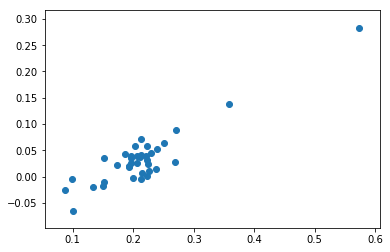

In [217]:
plt.scatter(normal_max_list, normal_min_list)

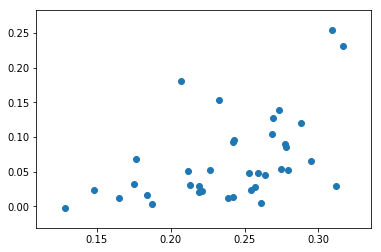

In [218]:
plt.scatter(abnormal_max_list, abnormal_min_list)

In [ ]:
# todo : lm VS fm linear plot